# Reading cloud radar data
The high resolution data has about 500 MB per file, which when read in over a remote source can lead to long wait times.
To reduce the wait times the data can be read in lazily using dask.
Intake will this do this by default.
Let's obtain the EUREC4A intake catalog:

In [1]:
import eurec4a
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")

## Available products
The `LIMRAD94` cloud radar offers multiple products which can be accessed using names and additional parameters.
Let's see which products and parameters are available for the cloud radar.
For the parameters, we are also interested in their valid range:

In [2]:
for key, source in cat.Meteor.LIMRAD94.items():
    desc = source.describe()
    user_parameters = desc.get("user_parameters", [])
    if len(user_parameters) > 0:
        params = " (" + ", ".join(p["name"] for p in user_parameters) + ")"
    else:
        params = ""
    print(f"{key}{params}: {desc['description']}")
    for parameter in user_parameters:
        print(f"    {parameter['name']}: {parameter['min']} ... {parameter['max']} default: {parameter['default']}")
    print()

high_res (date, version): daily heave corrected original resolution cloudradar data
    date: 2020-01-17 00:00:00 ... 2020-02-29 00:00:00 default: 2020-02-01 00:00:00
    version: 1.0 ... 1.1 default: 1.1

low_res (date): daily 30m 30s averaged radar reflectivity
    date: 2020-01-17 00:00:00 ... 2020-02-29 00:00:00 default: 2020-02-01 00:00:00



## Radar reflectivity
We'll have a look at the `high_res` data in version 1.1. We'll keep the default date for simplicity:

In [3]:
ds = cat.Meteor.LIMRAD94.high_res(version=1.1).to_dask()
ds

/usr/share/miniconda3/envs/how_to_eurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 720MB
Dimensions:                    (chirp: 3, time: 44447, range: 367)
Coordinates:
  * range                      (range) float32 1kB 313.0 335.4 ... 1.296e+04
  * time                       (time) datetime64[ns] 356kB 2020-02-01T00:00:0...
Dimensions without coordinates: chirp
Data variables: (12/23)
    NumSpectraAveraged         (chirp) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    Numfft                     float32 4B ...
    Nyquist_velocity           (chirp) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    Skew                       (time, range) float32 65MB dask.array<chunksize=(5556, 46), meta=np.ndarray>
    SurfRelHum                 (time) float32 178kB dask.array<chunksize=(44447,), meta=np.ndarray>
    Zh                         (time, range) float32 65MB dask.array<chunksize=(5556, 46), meta=np.ndarray>
    ...                         ...
    range_offsets              (chirp) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    time_shift                 (time, chirp) float32 533kB dask.array<chunksize=(22224, 3), meta=np.ndarray>
    v                          (time, range) float32 65MB dask.array<chunksize=(5556, 46), meta=np.ndarray>
    v_no_rolling_mean_applied  (time, range) float32 65MB dask.array<chunksize=(5556, 46), meta=np.ndarray>
    v_uncor                    (time, range) float32 65MB dask.array<chunksize=(5556, 46), meta=np.ndarray>
    width                      (time, range) float32 65MB dask.array<chunksize=(5556, 46), meta=np.ndarray>
Attributes: (12/20)
    Conventions:    CF-1.8
    _FillValue:     -999.0
    calibrations:   remove Precip. ghost: False\n, remove curtain ghost: True...
    campaign_id:    EUREC4A
    contact:        heike.kalesse@uni-leipzig.de
    day:            1
    ...             ...
    source:         94 GHz Cloud Radar LIMRAD94\nRadar type: Frequency Modula...
    system:         LIMRAD94
    title:          LIMRAD94 (SLDR) Doppler Cloud Radar, calibrated file
    version:        Variable names and dimensions prepared for upload to Aeri...
    version_id:     v1.1
    year:           2020

Explore the dataset and choose the variable you want to work with.
The variables are loaded lazily, i.e. only when their content is really required to complete the operation.
An example which forces the data to load is plotting, in this case only the radar reflectivity will be loaded.

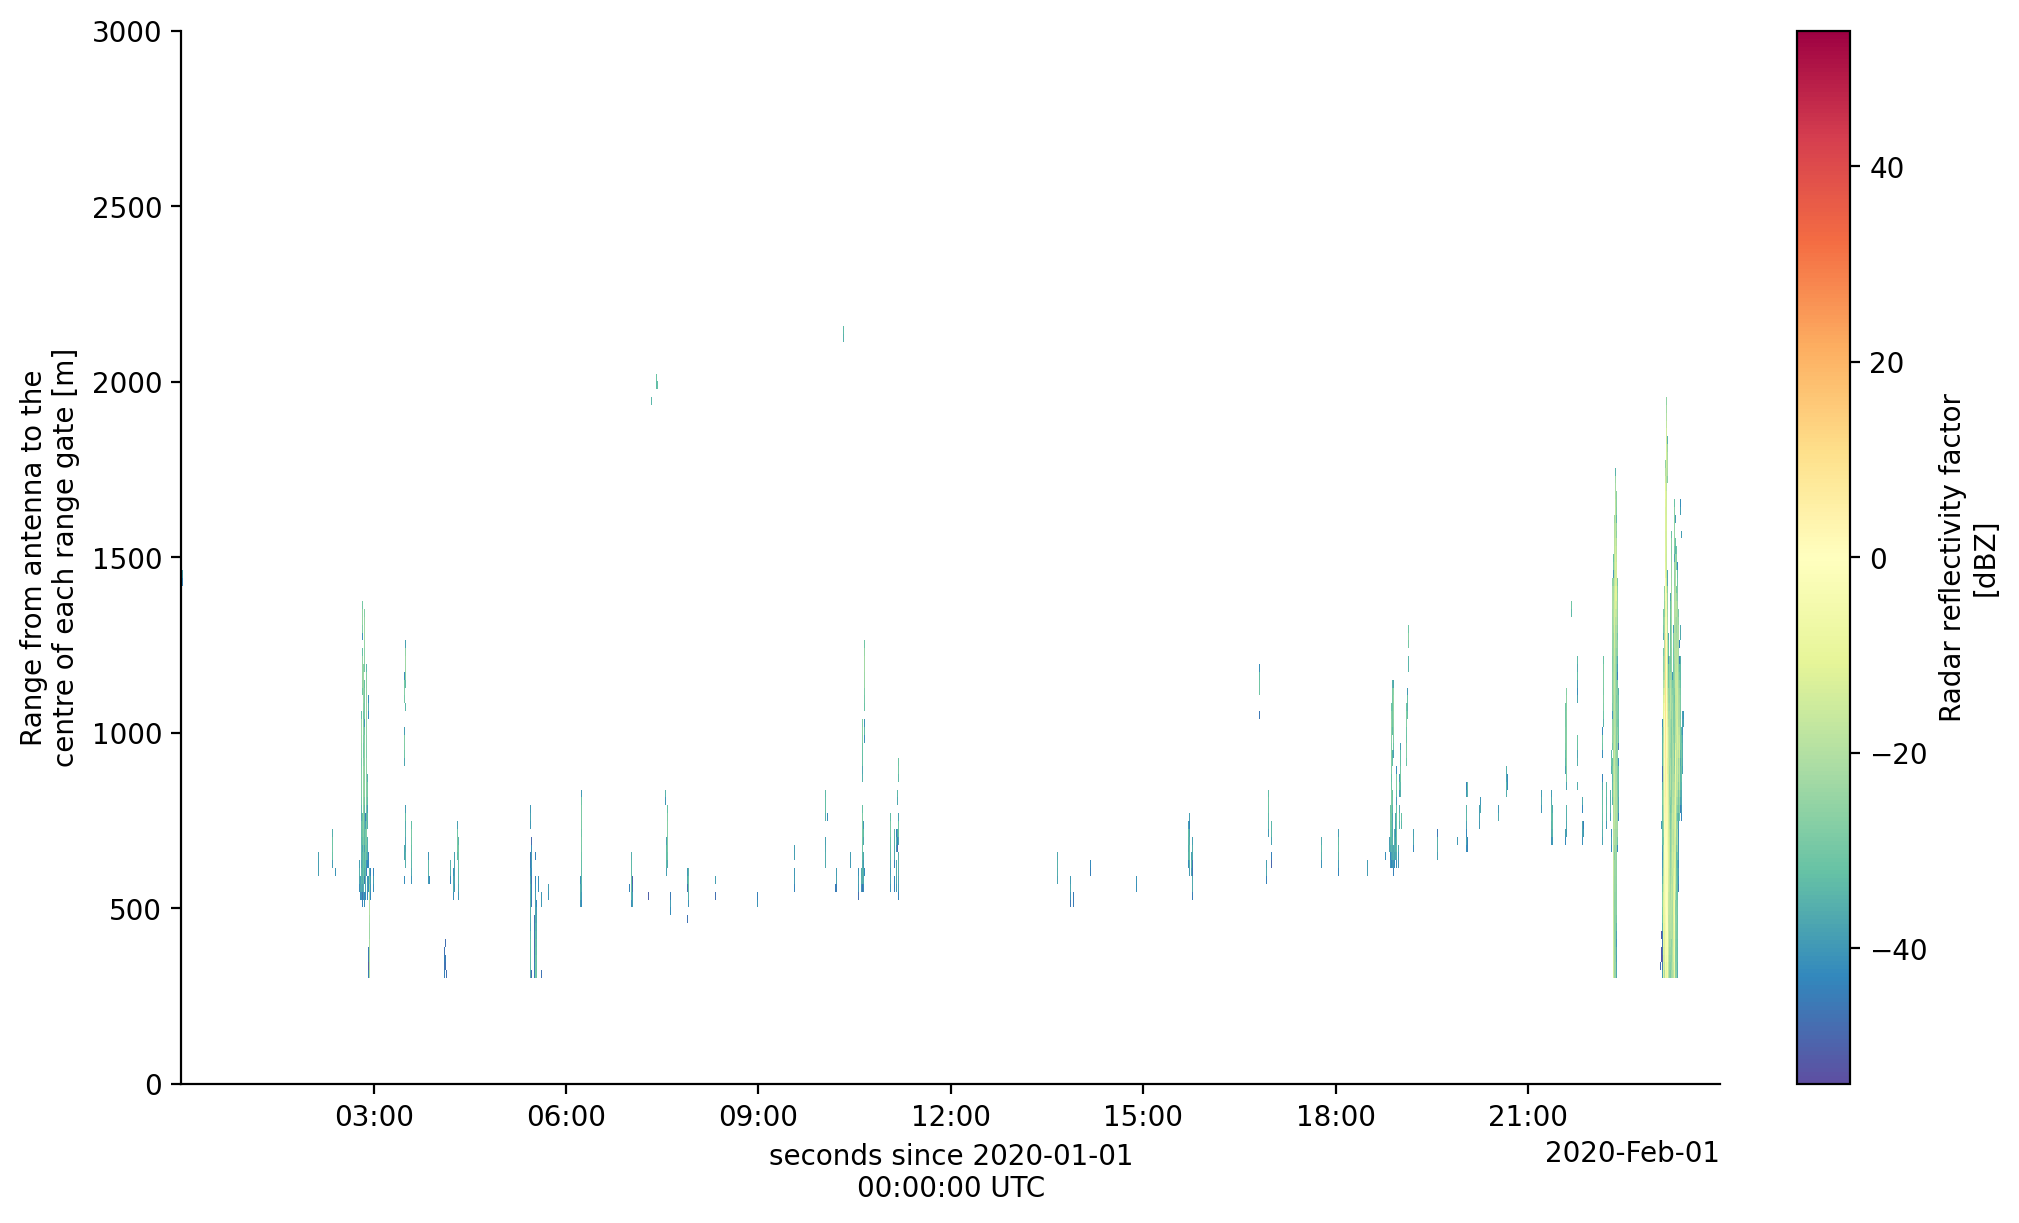

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
plt.style.use(pathlib.Path("./mplstyle/book"))

ds.Zh.plot(x='time', cmap="Spectral_r")  # plot the variable with time as the x axis
plt.ylim(0, 3000);